# Case #6
## Michael Catalano, Martin Garcia, Jeremy Otsap, Christian Nava

## 1. Replicate results from paper

In [1]:
import os
import logging
import logging.config
import numpy as np 
import pandas as pd
import tensorflow as tf
import pandas as pd 
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns

# Remove scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
# From https://arxiv.org/abs/1402.4735

#### Get working Directory

In [3]:
os.getcwd()

'C:\\Users\\Mike'

#### Get Data

In [4]:
# Downloads a file from a URL if it not already in the cache. Will save in .keraset/dataset folder
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

Contains 11,000,000 examples, each with 28 features, and a binary class label.

In [4]:
higgs = pd.read_csv('.keras/datasets/HIGGS.csv.gz',nrows = 250000, skiprows = 10)

Sample of 250,000 records from the first 2.5 million (skiprows of 10)

In [5]:
higgs.head()

,1.000000000000000000e+00,9.459739923477172852e-01,1.111244320869445801e+00,1.218337059020996094e+00,9.076390862464904785e-01,8.215369582176208496e-01,1.153243303298950195e+00,-3.654202818870544434e-01,-1.566054821014404297e+00,0.000000000000000000e+00,...,-4.510180354118347168e-01,6.365344673395156860e-02,3.101961374282836914e+00,8.290241360664367676e-01,9.806482791900634766e-01,9.943597912788391113e-01,9.082478284835815430e-01,7.758789062500000000e-01,7.833113670349121094e-01,7.251217961311340332e-01
0,0.00000,0.73936,-0.17829,0.82993,0.50454,-0.13022,0.96105,-0.35552,-1.71740,2.17308,...,0.77406,0.39882,3.10196,0.94454,1.02626,0.98220,0.54211,1.25098,0.83004,0.76131
1,1.00000,1.38410,0.11682,-1.17988,0.76291,-0.07978,1.01986,0.87732,1.27689,2.17308,...,0.84652,0.50481,3.10196,0.95932,0.80738,1.19181,1.22121,0.86114,0.92934,0.83830
2,1.00000,1.38355,0.88918,0.61853,1.08155,0.34461,0.95638,0.85454,-1.12921,2.17308,...,-1.63613,1.14407,0.00000,0.52224,0.73764,0.98620,1.34962,0.81279,0.95341,0.77972
3,1.00000,1.34365,0.83853,-1.06114,2.47202,-0.57263,1.51271,1.14369,0.85556,0.00000,...,2.39640,0.75729,0.00000,0.93402,0.84471,1.07784,1.40018,0.94777,1.00761,0.90102
4,0.00000,0.54701,-0.34971,-0.64666,2.04046,0.27646,0.54470,0.83870,1.72870,0.00000,...,-0.62924,1.57079,3.10196,0.68943,0.86723,1.08249,0.66414,0.35411,0.57995,0.81727


#### Preprocessing

In [6]:
# Rename columns
higgs.columns = ['label','lepton_pT','lepton_eta','lepton_phi','missing_energy_magnitude','missing_energy_phi','jet_1_pt','jet_1_eta','jet_1_phi','jet_1_b_tag','jet_2_pt','jet_2_eta','jet_2_phi','jet_2_b_tag','jet_3_pt','jet_3_eta','jet_3_phi','jet_3_b-tag','jet_4_pt','jet_4_eta','jet_4_phi','jet_4_b_tag','m_jj','m_jjj','m_lv','m_jlv','m_bb','m_wbb','m_wwbb']

In [7]:
higgs.head()

,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.00000,0.73936,-0.17829,0.82993,0.50454,-0.13022,0.96105,-0.35552,-1.71740,2.17308,...,0.77406,0.39882,3.10196,0.94454,1.02626,0.98220,0.54211,1.25098,0.83004,0.76131
1,1.00000,1.38410,0.11682,-1.17988,0.76291,-0.07978,1.01986,0.87732,1.27689,2.17308,...,0.84652,0.50481,3.10196,0.95932,0.80738,1.19181,1.22121,0.86114,0.92934,0.83830
2,1.00000,1.38355,0.88918,0.61853,1.08155,0.34461,0.95638,0.85454,-1.12921,2.17308,...,-1.63613,1.14407,0.00000,0.52224,0.73764,0.98620,1.34962,0.81279,0.95341,0.77972
3,1.00000,1.34365,0.83853,-1.06114,2.47202,-0.57263,1.51271,1.14369,0.85556,0.00000,...,2.39640,0.75729,0.00000,0.93402,0.84471,1.07784,1.40018,0.94777,1.00761,0.90102
4,0.00000,0.54701,-0.34971,-0.64666,2.04046,0.27646,0.54470,0.83870,1.72870,0.00000,...,-0.62924,1.57079,3.10196,0.68943,0.86723,1.08249,0.66414,0.35411,0.57995,0.81727


In [8]:
higgs.describe(include='all')

,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,...,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000
mean,0.52776,0.99242,0.00036,-0.00186,0.99711,-0.00341,0.98970,-0.00418,-0.00031,0.99981,...,-0.00159,-0.00048,0.99581,1.03449,1.02434,1.05057,1.01053,0.97331,1.03333,0.95999
std,0.49923,0.56564,1.00673,1.00591,0.59799,1.00660,0.47523,1.00894,1.00769,1.02791,...,1.00898,1.00664,1.39814,0.66315,0.37631,0.16456,0.39852,0.52361,0.36465,0.31314
min,0.00000,0.27470,-2.43498,-1.74251,0.00086,-1.74394,0.13998,-2.96973,-1.74124,0.00000,...,-2.49726,-1.74269,0.00000,0.10967,0.24532,0.13301,0.15747,0.04813,0.30335,0.35094
25%,0.00000,0.59185,-0.73637,-0.87360,0.57645,-0.87491,0.67817,-0.69220,-0.86865,0.00000,...,-0.71669,-0.87328,0.00000,0.79098,0.84619,0.98578,0.76834,0.67452,0.81977,0.77038
50%,1.00000,0.85392,-0.00005,0.00042,0.89068,-0.00448,0.89354,-0.00498,-0.00382,1.08654,...,-0.00462,-0.00193,0.00000,0.89527,0.95025,0.98976,0.91708,0.87394,0.94715,0.87169
75%,1.00000,1.23806,0.73919,0.86766,1.29174,0.86920,1.16918,0.68224,0.87108,2.17308,...,0.71410,0.86994,3.10196,1.02520,1.08271,1.02044,1.14223,1.13997,1.14008,1.05973
max,1.00000,7.80589,2.43487,1.74324,8.77406,1.74323,7.07693,2.96967,1.74145,2.17308,...,2.49801,1.74337,3.10196,18.42883,10.03827,5.64642,10.46832,13.73569,8.43236,6.01565


In [9]:
higgs.dtypes

label                       float64
lepton_pT                   float64
lepton_eta                  float64
lepton_phi                  float64
missing_energy_magnitude    float64
missing_energy_phi          float64
jet_1_pt                    float64
jet_1_eta                   float64
jet_1_phi                   float64
jet_1_b_tag                 float64
jet_2_pt                    float64
jet_2_eta                   float64
jet_2_phi                   float64
jet_2_b_tag                 float64
jet_3_pt                    float64
jet_3_eta                   float64
jet_3_phi                   float64
jet_3_b-tag                 float64
jet_4_pt                    float64
jet_4_eta                   float64
jet_4_phi                   float64
jet_4_b_tag                 float64
m_jj                        float64
m_jjj                       float64
m_lv                        float64
m_jlv                       float64
m_bb                        float64
m_wbb                       

In [10]:
#change label to int
higgs["label"] = higgs["label"].astype(int)

In [11]:
dataset = higgs.values

In [12]:
# split into input (X) and output (Y) variables
X = dataset[:,1:29].astype(float)
Y = dataset[:,0]

In [13]:
# visualize data
X[0:3]

array([[ 0.73935676, -0.17829043,  0.82993424,  0.50453907, -0.13021675,
         0.96105134, -0.35551798, -1.71739936,  2.17307615,  0.62095606,
        -0.48174104, -1.19919324,  0.        ,  0.9826014 ,  0.08118503,
        -0.29032364,  0.        ,  1.06466293,  0.77406496,  0.39882034,
         3.10196137,  0.94453603,  1.02626061,  0.98219675,  0.54211468,
         1.25097895,  0.83004463,  0.76130795],
       [ 1.3840977 ,  0.11682209, -1.17987895,  0.76291257, -0.07978227,
         1.01986313,  0.87731826,  1.27688718,  2.17307615,  0.3312521 ,
         1.40952349, -1.47438884,  0.        ,  1.28273821,  0.73747438,
        -0.22541961,  0.        ,  1.55975306,  0.84652054,  0.50480855,
         3.10196137,  0.95932466,  0.80737603,  1.19181359,  1.22121036,
         0.86114126,  0.9293409 ,  0.83830237],
       [ 1.38354874,  0.88917929,  0.61853206,  1.08154702,  0.34460557,
         0.95637935,  0.85454297, -1.12920702,  2.17307615,  0.54566574,
        -0.30786517, -0.6232

In [14]:
Y[0:3]

array([0., 1., 1.])

### Normalization

In [15]:
from sklearn import preprocessing

# Normalize X values
normalized_X = preprocessing.normalize(X, norm='l2', axis=1, copy=True, return_norm=False)

In [16]:
normalized_X[0:3]

array([[ 0.13295555, -0.03206125,  0.14924374,  0.09072923, -0.02341635,
         0.172822  , -0.06393137, -0.30883302,  0.39077555,  0.11166403,
        -0.08662956, -0.2156461 ,  0.        ,  0.17669726,  0.01459918,
        -0.05220773,  0.        ,  0.19145406,  0.13919699,  0.07171826,
         0.55781325,  0.16985212,  0.18454832,  0.17662449,  0.0974863 ,
         0.22495852,  0.14926359,  0.13690295],
       [ 0.22335446,  0.0188518 , -0.19039929,  0.12311264, -0.01287462,
         0.16457724,  0.1415745 ,  0.20605369,  0.3506734 ,  0.05345478,
         0.22745747, -0.23792491,  0.        ,  0.20699789,  0.11900763,
        -0.03637639,  0.        ,  0.2517003 ,  0.13660462,  0.08146191,
         0.50056936,  0.15480803,  0.13028779,  0.19232521,  0.19706902,
         0.13896399,  0.14996949,  0.13527844],
       [ 0.25562701,  0.1642864 ,  0.11428112,  0.19982862,  0.06366996,
         0.17670241,  0.15788693, -0.20863437,  0.40150155,  0.10081821,
        -0.05688174, -0.1151

## Neural Network Model Building

#### Model replication from the paper

In [17]:
# New train/test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(normalized_X, Y, test_size=0.20, random_state=1776)

In [18]:
from time import time
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
es = EarlyStopping(min_delta=0.001,patience=10)

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K

# set learning rate
optimizer = tf.keras.optimizers.Adam(lr=0.05)

model1 = Sequential()
model1.add(Dense(500, input_dim=28, activation='tanh'))
model1.add(Dense(500, activation='tanh'))
model1.add(Dense(500, activation='tanh'))
model1.add(Dense(500, activation='tanh'))
model1.add(Dense(1, activation='sigmoid'))
# Compile model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               14500     
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 501       
Total params: 766,501
Trainable params: 766,501
Non-trainable params: 0
_________________________________________________________________


In [21]:
# fit model
history1 = model1.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=100, batch_size=500,callbacks=[es])

Epoch 1/100
400/400 [==============================] - 7s 18ms/step - loss: 0.6533 - accuracy: 0.6133 - val_loss: 0.6439 - val_accuracy: 0.6291
Epoch 2/100
400/400 [==============================] - 7s 18ms/step - loss: 0.6444 - accuracy: 0.6265 - val_loss: 0.6393 - val_accuracy: 0.6334
Epoch 3/100
400/400 [==============================] - 7s 18ms/step - loss: 0.6269 - accuracy: 0.6472 - val_loss: 0.6131 - val_accuracy: 0.6594
Epoch 4/100
400/400 [==============================] - 7s 18ms/step - loss: 0.6084 - accuracy: 0.6671 - val_loss: 0.5987 - val_accuracy: 0.6756
Epoch 5/100
400/400 [==============================] - 7s 18ms/step - loss: 0.5982 - accuracy: 0.6771 - val_loss: 0.5945 - val_accuracy: 0.6805
Epoch 6/100
400/400 [==============================] - 7s 18ms/step - loss: 0.5883 - accuracy: 0.6858 - val_loss: 0.5820 - val_accuracy: 0.6880
Epoch 7/100
400/400 [==============================] - 7s 18ms/step - loss: 0.5819 - accuracy: 0.6901 - val_loss: 0.5719 - val_accuracy:

In [22]:
from sklearn.metrics import roc_curve

y_pred_keras = model1.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [23]:
# auc metric for model 1
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.7981580146367151

80% AUC using the book's parameters

In [24]:
# accuracy
scores_rnn = model1.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', scores_rnn[1])

Test accuracy: 0.7196400165557861


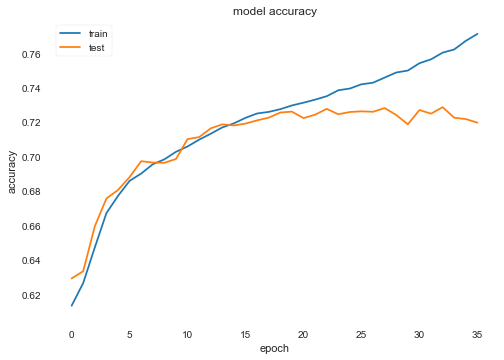

In [25]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

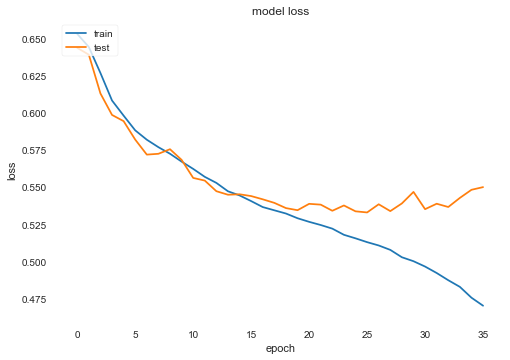

In [26]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

I'll use a baseline Random Forest Classifier to compare with our Neural Networks

In [27]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests - my simple model to compare with
rf = RandomForestClassifier(max_depth=10, n_estimators=30)
rf.fit(x_train, y_train)

y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

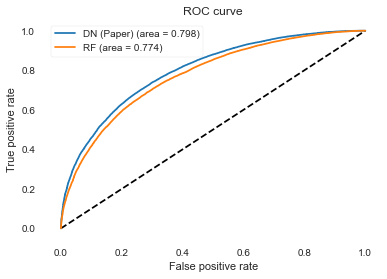

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='DN (Paper) (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### NN #2: Playing around with different parameters

In [29]:
# train/test split (should match above)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(normalized_X, Y, test_size=0.20, random_state=1776)

In [30]:
from time import time
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
es = EarlyStopping(min_delta=0.001,patience=10)

In [31]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import add, Input
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, TimeDistributed, Bidirectional, Lambda
from tensorflow.keras.layers import SimpleRNN as RNN

model2 = Sequential()
model2.add(Dense(100, input_dim=28, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))
# Compile model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We've done a few things differently, increased the min_delta threshold, lowered the neurons in each hidden layer, added a dropout after every additional hidden layer, and changed the hidden layer activations to Relu.

In [32]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               2900      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)               

In [33]:
# fit model
history2 = model2.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=300, batch_size=500,callbacks=[es])

Epoch 1/300
400/400 [==============================] - 1s 3ms/step - loss: 0.6633 - accuracy: 0.5926 - val_loss: 0.6319 - val_accuracy: 0.6403
Epoch 2/300
400/400 [==============================] - 1s 3ms/step - loss: 0.6349 - accuracy: 0.6378 - val_loss: 0.6163 - val_accuracy: 0.6565
Epoch 3/300
400/400 [==============================] - 1s 3ms/step - loss: 0.6208 - accuracy: 0.6548 - val_loss: 0.6043 - val_accuracy: 0.6723
Epoch 4/300
400/400 [==============================] - 1s 3ms/step - loss: 0.6108 - accuracy: 0.6659 - val_loss: 0.5948 - val_accuracy: 0.6808
Epoch 5/300
400/400 [==============================] - 1s 3ms/step - loss: 0.6028 - accuracy: 0.6741 - val_loss: 0.5893 - val_accuracy: 0.6842
Epoch 6/300
400/400 [==============================] - 1s 3ms/step - loss: 0.5985 - accuracy: 0.6774 - val_loss: 0.5854 - val_accuracy: 0.6876
Epoch 7/300
400/400 [==============================] - 1s 3ms/step - loss: 0.5940 - accuracy: 0.6815 - val_loss: 0.5845 - val_accuracy: 0.6873

In [34]:
from sklearn.metrics import roc_curve

y_pred_keras = model2.predict(x_test).ravel()
fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(y_test, y_pred_keras)

In [35]:
# auc metric for model 2
from sklearn.metrics import auc
auc_keras2 = auc(fpr_keras2, tpr_keras2)
auc_keras2

0.8045275471535516

In [36]:
# Accuracy
scores_rnn = model2.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', scores_rnn[1])

Test accuracy: 0.7260599732398987


#### Comparisons Between NN Models

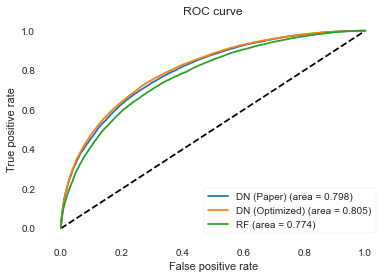

In [37]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='DN (Paper) (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras2, tpr_keras2, label='DN (Optimized) (area = {:.3f})'.format(auc_keras2))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

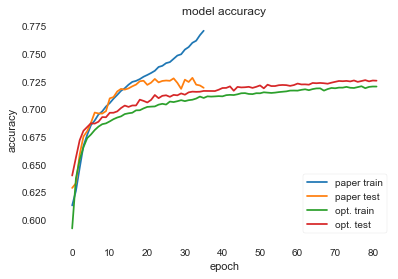

In [38]:
# summarized history for accuracy - both models
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['paper train', 'paper test','opt. train','opt. test'], loc='lower right')
plt.show()

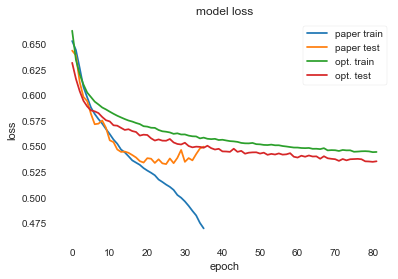

In [39]:
# summarized history for loss - both models
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['paper train', 'paper test','opt. train','opt. test'], loc='upper right')
plt.show()

#### NN #3: Let's see what h2o can do for us

In [128]:
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [129]:
h2o.init()           
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from C:\Users\Mike\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Mike\AppData\Local\Temp\tmpuhjg8av3
  JVM stdout: C:\Users\Mike\AppData\Local\Temp\tmpuhjg8av3\h2o_Mike_started_from_python.out
  JVM stderr: C:\Users\Mike\AppData\Local\Temp\tmpuhjg8av3\h2o_Mike_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_Mike_160pju
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.990 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"accepting new members, healthy"


In [148]:
hf = h2o.H2OFrame(higgs)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
# change label to a factor so h2o recognizes it as a classification problem
hf['label'] = hf['label'].asfactor()

In [159]:
train, valid = hf.split_frame([0.8])
higgs_X = hf.col_names[1:]
higgs_y = hf.col_names[0]

In [162]:
# check out our training set
train.describe()

Rows:199991
Cols:29




,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,jet_2_pt,jet_2_eta,jet_2_phi,jet_2_b_tag,jet_3_pt,jet_3_eta,jet_3_phi,jet_3_b-tag,jet_4_pt,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
type,enum,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,,0.27469664812088007,-2.434976100921631,-1.7425082921981812,0.0012828720500692723,-1.7439435720443723,0.13997583091259003,-2.9697251319885254,-1.7412374019622805,0.0,0.18910706043243408,-2.913089513778687,-1.7423716783523555,0.0,0.2636076211929321,-2.7296628952026367,-1.7420687675476072,0.0,0.36535415053367615,-2.4972648620605473,-1.742690801620483,0.0,0.10967338830232622,0.3031438887119293,0.13301192224025726,0.15747258067131042,0.04812500998377799,0.30334970355033875,0.35093879699707037
mean,,0.9928443690563462,-0.001496502046137673,-0.0012823661965364822,0.9966130585343017,-0.0039009248026472777,0.9904257802243441,-0.005019716836607275,-0.0003910278346569606,0.9996980455334196,0.9921096713431234,0.0029559244215721712,0.0017081462627894,1.0012503130271866,0.9935207512552138,0.00218139168097345,0.0002614442240344559,1.00321740480538,0.986635379065815,-0.0011317309629937744,-0.001083707460083837,0.9967670833033097,1.0342043850314853,1.024055928080683,1.0510002955916609,1.0108612270061257,0.9736334116959872,1.0333720595914928,0.9600541221973059
maxs,,7.80588674545288,2.4348678588867183,1.7432359457015991,8.774063110351562,1.7432292699813845,7.076932430267333,2.9696741104125977,1.7414537668228147,2.1730761528015137,11.64708137512207,2.9122383594512935,1.7431747913360591,2.2148721218109126,8.509907722473145,2.730008840560912,1.7428839206695554,2.548224449157715,7.705783367156982,2.498008966445923,1.743372321128845,3.1019613742828365,18.4288272857666,10.038272857666016,4.565247535705566,10.468321800231934,13.735691070556642,8.43235969543457,6.015646934509276
sigma,,0.5668877686202813,1.0074774842183913,1.0059046750910174,0.597689656887067,1.00683894184852,0.4760948156895983,1.0087683242402925,1.0073358891859454,1.0280035640832847,0.49968521967613116,1.0076459522800154,1.0073325432151232,1.0490474022912533,0.4877214180553597,1.009742076714189,1.0046395807673845,1.1950371675081188,0.5046959418536049,1.008832661455431,1.0064233192284868,1.3986422779965493,0.6628883302233122,0.37637667562954824,0.16601081425172767,0.399396640128361,0.5245218960044914,0.36520726273136084,0.3131999293530749
zeros,,0,0,0,0,0,0,0,0,98142,0,0,0,100236,0,0,0,113749,0,0,0,129816,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0.739356756210327,-0.1782904267311096,0.8299342393875122,0.5045390725135802,-0.13021674752235413,0.961051344871521,-0.3555179834365845,-1.7173993587493894,2.1730761528015137,0.6209560632705688,-0.4817410409450531,-1.199193239212036,0.0,0.9826014041900634,0.08118502795696257,-0.29032364487648005,0.0,1.0646629333496092,0.7740649580955506,0.3988203406333923,3.1019613742828365,0.9445360302925108,1.0262606143951416,0.9821967482566832,0.5421146750450134,1.250978946685791,0.8300446271896361,0.761307954788208
1,1,1.3840976953506468,0.11682209372520444,-1.1798789501190183,0.7629125714302065,-0.07978226989507675,1.0198631286621092,0.8773182630538942,1.2768871784210205,2.1730761528015137,0.33125209808349604,1.4095234870910645,-1.4743888378143308,0.0,1.282738208770752,0.7374743819236755,-0.22541961073875424,0.0,1.5597530603408811,0.8465205430984498,0.5048085451126099,3.1019613742828365,0.9593246579170226,0.8073760271072387,1.1918135881423952,1.2212103605270384,0.8611412644386292,0.9293408989906312,0.8383023738861084
2,1,1.3436527252197263,0.8385329246520996,-1.0611385107040403,2.472015142440796,-0.5726317167282104,1.5127099752426147,1.1436901092529297,0.8555619716644287,0.0,0.88422030210495,1.4746055603027344,-1.36064875125885,1.1074360609054563,1.5872656106948853,2.2348334789276

In [172]:
higgs_model_v1 = H2ODeepLearningEstimator(model_id = 'higgs_v1', epochs = 10, variable_importances = False)
higgs_model_v1.train(higgs_X, higgs_y, training_frame = train, validation_frame = valid)
print(higgs_model_v1)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  higgs_v1


Status of Neuron Layers: predicting label, 2-class classification, bernoulli distribution, CrossEntropy loss, 46,402 weights/biases, 556.3 KB, 2,000,157 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,28,Input,0.00000,,,,,,,,,
1,,2,200,Rectifier,0.00000,0.00000,0.00000,0.00580,0.00215,0.00000,-0.01909,0.27905,-0.26378,0.22769
2,,3,200,Rectifier,0.00000,0.00000,0.00000,0.04542,0.06099,0.00000,-0.05817,0.12264,0.66658,0.24769
3,,4,2,Softmax,,0.00000,0.00000,0.00310,0.00197,0.00000,0.02060,0.34415,-0.02667,0.30956




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1668527636286532
RMSE: 0.40847614817594086
LogLoss: 0.5002911642708139
Mean Per-Class Error: 0.2527245788763892
AUC: 0.8335403208593473
AUCPR: 0.842603974265337
Gini: 0.6670806417186945

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41742908268080586: 


,,0,1,Error,Rate
0,0,2897.00000,1937.00000,0.4007,(1937.0/4834.0)
1,1,701.00000,4492.00000,0.135,(701.0/5193.0)
2,Total,3598.00000,6429.00000,0.2631,(2638.0/10027.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.41743,0.77302,239.00000
1,max f2,0.18761,0.86647,328.00000
2,max f0point5,0.66540,0.77507,140.00000
3,max accuracy,0.53397,0.74768,193.00000
4,max precision,0.99464,1.00000,0.00000
5,max recall,0.00399,1.00000,398.00000
6,max specificity,0.99464,1.00000,0.00000
7,max absolute_mcc,0.53397,0.49456,193.00000
8,max min_per_class_accuracy,0.54933,0.74581,187.00000
9,max mean_per_class_accuracy,0.53905,0.74728,191.00000



Gains/Lift Table: Avg response rate: 51.79 %, avg score: 53.49 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01007,0.97848,1.87352,1.87352,0.97030,0.98515,0.97030,0.98515,0.01887,0.01887,87.35159,87.35159,0.01825
1,2,0.02005,0.96979,1.93087,1.90205,1.00000,0.97395,0.98507,0.97958,0.01926,0.03813,93.08685,90.20495,0.03751
2,3,0.03002,0.96329,1.91156,1.90521,0.99000,0.96662,0.98671,0.97527,0.01906,0.05719,91.15598,90.52091,0.05636
3,4,0.04009,0.95590,1.85440,1.89244,0.96040,0.95925,0.98010,0.97125,0.01868,0.07587,85.43984,89.24432,0.07422
4,5,0.05006,0.94898,1.89225,1.89240,0.98000,0.95242,0.98008,0.96750,0.01887,0.09474,89.22511,89.24050,0.09267
5,6,0.10003,0.91175,1.80369,1.84809,0.93413,0.93064,0.95713,0.94909,0.09012,0.18486,80.36855,84.80895,0.17597
6,7,0.15000,0.87569,1.72660,1.80762,0.89421,0.89436,0.93617,0.93086,0.08627,0.27113,72.66049,80.76216,0.25127
7,8,0.20006,0.83424,1.62701,1.76242,0.84263,0.85522,0.91276,0.91193,0.08146,0.35259,62.70067,76.24228,0.31639
8,9,0.29999,0.74224,1.51656,1.68052,0.78543,0.78786,0.87035,0.87060,0.15155,0.50414,51.65604,68.05232,0.42346
9,10,0.40052,0.65007,1.27767,1.57941,0.66171,0.69527,0.81798,0.82659,0.12844,0.63258,27.76679,57.94081,0.48136




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17726013570936167
RMSE: 0.4210227258822992
LogLoss: 0.5285695973354901
Mean Per-Class Error: 0.2689006774753162
AUC: 0.8110262065775843
AUCPR: 0.8242550097338726
Gini: 0.6220524131551686

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39787454436856207: 


,,0,1,Error,Rate
0,0,13150.00000,10349.00000,0.4404,(10349.0/23499.0)
1,1,3705.00000,22805.00000,0.1398,(3705.0/26510.0)
2,Total,16855.00000,33154.00000,0.281,(14054.0/50009.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.39787,0.76445,247.00000
1,max f2,0.13204,0.86451,351.00000
2,max f0point5,0.63266,0.75826,153.00000
3,max accuracy,0.52851,0.73137,196.00000
4,max precision,0.98687,0.97500,3.00000
5,max recall,0.00219,1.00000,399.00000
6,max specificity,0.99609,0.99991,0.00000
7,max absolute_mcc,0.58897,0.46246,172.00000
8,max min_per_class_accuracy,0.54368,0.72939,190.00000
9,max mean_per_class_accuracy,0.58897,0.73110,172.00000



Gains/Lift Table: Avg response rate: 53.01 %, avg score: 53.84 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01002,0.98040,1.81864,1.81864,0.96407,0.98642,0.96407,0.98642,0.01822,0.01822,81.86446,81.86446,0.01745
1,2,0.02002,0.97130,1.82228,1.82046,0.96600,0.97557,0.96503,0.98100,0.01822,0.03644,82.22819,82.04615,0.03495
2,3,0.03001,0.96377,1.79964,1.81353,0.95400,0.96756,0.96136,0.97652,0.01799,0.05443,79.96449,81.35272,0.05196
3,4,0.04001,0.95656,1.75437,1.79875,0.93000,0.96020,0.95352,0.97245,0.01754,0.07197,75.43708,79.87455,0.06802
4,5,0.05001,0.94944,1.78833,1.79666,0.94800,0.95306,0.95242,0.96857,0.01788,0.08985,78.83264,79.66625,0.08479
5,6,0.10000,0.91426,1.74381,1.77024,0.92440,0.93231,0.93841,0.95044,0.08717,0.17703,74.38069,77.02400,0.16392
6,7,0.15001,0.87561,1.65939,1.73328,0.87965,0.89533,0.91882,0.93207,0.08299,0.26002,65.93860,73.32837,0.23410
7,8,0.20000,0.83171,1.54158,1.68537,0.81720,0.85414,0.89342,0.91259,0.07707,0.33708,54.15826,68.53680,0.29172
8,9,0.30001,0.74158,1.43302,1.60125,0.75965,0.78740,0.84883,0.87086,0.14330,0.48038,43.30155,60.12505,0.38387
9,10,0.40057,0.65007,1.27912,1.52038,0.67807,0.69562,0.80596,0.82687,0.12863,0.60902,27.91197,52.03801,0.44360




Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-07-15 22:29:31,0.000 sec,None,0.00000,0,0.00000,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,,2020-07-15 22:29:33,2.517 sec,46287 obs/sec,0.49854,1,99703.00000,0.44100,0.57023,0.22106,...,0.78000,1.81616,0.33450,0.44374,0.57804,0.20951,0.76766,0.77905,1.75840,0.33028
2,,2020-07-15 22:29:39,8.272 sec,65489 obs/sec,2.49724,5,499425.00000,0.42507,0.53580,0.27633,...,0.81291,1.91175,0.28862,0.42875,0.54539,0.26203,0.79743,0.80906,1.82241,0.30606
3,,2020-07-15 22:29:44,13.417 sec,71946 obs/sec,4.49899,9,899757.00000,0.41395,0.51142,0.31371,...,0.83380,1.89263,0.27177,0.42258,0.53189,0.28312,0.80818,0.82163,1.82241,0.29021
4,,2020-07-15 22:29:50,19.367 sec,77031 obs/sec,7.00129,14,1400195.00000,0.40848,0.50029,0.33173,...,0.84260,1.87352,0.26309,0.42102,0.52857,0.28838,0.81103,0.82426,1.81864,0.28103
5,,2020-07-15 22:29:56,25.134 sec,80293 obs/sec,9.50071,19,1900056.00000,0.40373,0.49029,0.34718,...,0.85019,1.93087,0.25082,0.42317,0.53300,0.28112,0.80770,0.82178,1.82241,0.28063
6,,2020-07-15 22:29:57,26.430 sec,81046 obs/sec,10.00124,20,2000157.00000,0.40387,0.49006,0.34673,...,0.85050,1.91175,0.25421,0.42270,0.53323,0.28270,0.80958,0.82306,1.80735,0.28343
7,,2020-07-15 22:29:57,26.703 sec,81033 obs/sec,10.00124,20,2000157.00000,0.40848,0.50029,0.33173,...,0.84260,1.87352,0.26309,0.42102,0.52857,0.28838,0.81103,0.82426,1.81864,0.28103


In [173]:
higgs_model_v1.auc(train=True, valid=True, xval=False)

{'train': 0.8335403208593473, 'valid': 0.8110262065775843}

Highest AUC for any model, although it doesnt generalize the best. Let's include some dropouts and see what it does

In [170]:
higgs_model_v2 = H2ODeepLearningEstimator(model_id = 'higgs_v2', epochs = 10, variable_importances = True, activation = 'rectifier_with_dropout',  loss="CrossEntropy", balance_classes=False)
higgs_model_v2.train(higgs_X, higgs_y, training_frame = train, validation_frame = valid)
print(higgs_model_v2)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  higgs_v1


Status of Neuron Layers: predicting label, 2-class classification, bernoulli distribution, CrossEntropy loss, 46,402 weights/biases, 556.6 KB, 1,999,962 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,28,Input,0.00000,,,,,,,,,
1,,2,200,RectifierDropout,50.00000,0.00000,0.00000,0.00387,0.00184,0.00000,-0.02030,0.26811,-0.30638,0.24871
2,,3,200,RectifierDropout,50.00000,0.00000,0.00000,0.02007,0.03039,0.00000,-0.07072,0.15910,0.24621,0.24139
3,,4,2,Softmax,,0.00000,0.00000,0.00367,0.00353,0.00000,-0.00410,0.32992,0.04060,0.11848




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1859881758299366
RMSE: 0.4312634645201661
LogLoss: 0.5489934554964819
Mean Per-Class Error: 0.27461432569264577
AUC: 0.7986135762809996
AUCPR: 0.8167891586224978
Gini: 0.5972271525619992

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4960521177686097: 


,,0,1,Error,Rate
0,0,2657.00000,2005.00000,0.4301,(2005.0/4662.0)
1,1,833.00000,4453.00000,0.1576,(833.0/5286.0)
2,Total,3490.00000,6458.00000,0.2853,(2838.0/9948.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.49605,0.75834,225.00000
1,max f2,0.23146,0.86175,334.00000
2,max f0point5,0.59364,0.74749,168.00000
3,max accuracy,0.55399,0.72618,191.00000
4,max precision,0.98432,1.00000,0.00000
5,max recall,0.06462,1.00000,389.00000
6,max specificity,0.98432,1.00000,0.00000
7,max absolute_mcc,0.55399,0.45053,191.00000
8,max min_per_class_accuracy,0.55808,0.72244,189.00000
9,max mean_per_class_accuracy,0.55399,0.72539,191.00000



Gains/Lift Table: Avg response rate: 53.14 %, avg score: 55.98 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01005,0.94410,1.86313,1.86313,0.99000,0.95485,0.99000,0.95485,0.01873,0.01873,86.31328,86.31328,0.01851
1,2,0.02000,0.93400,1.84393,1.85358,0.97980,0.93883,0.98492,0.94688,0.01835,0.03708,84.39331,85.35812,0.03644
2,3,0.03006,0.92438,1.80667,1.83789,0.96000,0.92908,0.97659,0.94093,0.01816,0.05524,80.66742,83.78932,0.05374
3,4,0.04001,0.91455,1.82492,1.83467,0.96970,0.91913,0.97487,0.93551,0.01816,0.07340,82.49235,83.46671,0.07126
4,5,0.05006,0.90559,1.75022,1.81771,0.93000,0.91015,0.96586,0.93042,0.01759,0.09100,75.02157,81.77090,0.08735
5,6,0.10002,0.86180,1.71534,1.76658,0.91147,0.88191,0.93869,0.90618,0.08570,0.17669,71.53409,76.65764,0.16361
6,7,0.15008,0.82032,1.62498,1.71935,0.86345,0.84076,0.91360,0.88436,0.08135,0.25804,62.49789,71.93456,0.23037
7,8,0.20004,0.76854,1.49950,1.66444,0.79678,0.79521,0.88442,0.86210,0.07491,0.33295,49.95033,66.44402,0.28362
8,9,0.30006,0.67738,1.38451,1.57113,0.73568,0.72208,0.83484,0.81542,0.13848,0.47143,38.45117,57.11307,0.36569
9,10,0.39998,0.60571,1.27041,1.49601,0.67505,0.63862,0.79492,0.77126,0.12694,0.59837,27.04125,49.60078,0.42334




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1863687927306227
RMSE: 0.4317045201646871
LogLoss: 0.5500112748416384
Mean Per-Class Error: 0.2780698502078365
AUC: 0.7978336437793793
AUCPR: 0.8137657729418974
Gini: 0.5956672875587585

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4739212211952805: 


,,0,1,Error,Rate
0,0,12051.00000,11448.00000,0.4872,(11448.0/23499.0)
1,1,3439.00000,23071.00000,0.1297,(3439.0/26510.0)
2,Total,15490.00000,34519.00000,0.2977,(14887.0/50009.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.47392,0.75607,236.00000
1,max f2,0.24479,0.86155,329.00000
2,max f0point5,0.59465,0.74429,171.00000
3,max accuracy,0.54859,0.72293,198.00000
4,max precision,0.95966,0.98734,5.00000
5,max recall,0.05042,1.00000,392.00000
6,max specificity,0.99689,0.99996,0.00000
7,max absolute_mcc,0.55973,0.44338,191.00000
8,max min_per_class_accuracy,0.56130,0.71977,190.00000
9,max mean_per_class_accuracy,0.55973,0.72193,191.00000



Gains/Lift Table: Avg response rate: 53.01 %, avg score: 56.29 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01002,0.94414,1.82618,1.82618,0.96806,0.95613,0.96806,0.95613,0.01829,0.01829,82.61753,82.61753,0.01761
1,2,0.02002,0.93242,1.83737,1.83177,0.97400,0.93786,0.97103,0.94700,0.01837,0.03667,83.73733,83.17687,0.03543
2,3,0.03001,0.92225,1.78078,1.81478,0.94400,0.92745,0.96203,0.94049,0.01780,0.05447,78.07807,81.47840,0.05204
3,4,0.04001,0.91257,1.82228,1.81666,0.96600,0.91737,0.96302,0.93471,0.01822,0.07269,82.22819,81.66576,0.06954
4,5,0.05001,0.90397,1.77324,1.80798,0.94000,0.90835,0.95842,0.92944,0.01773,0.09042,77.32350,80.79765,0.08599
5,6,0.10000,0.86457,1.70231,1.75515,0.90240,0.88334,0.93041,0.90640,0.08510,0.17552,70.23056,75.51516,0.16071
6,7,0.15001,0.82507,1.64807,1.71945,0.87365,0.84576,0.91149,0.88618,0.08242,0.25794,64.80720,71.94537,0.22968
7,8,0.20000,0.77536,1.53706,1.67386,0.81480,0.80087,0.88732,0.86486,0.07684,0.33478,53.70552,67.38632,0.28682
8,9,0.30001,0.67886,1.37907,1.57560,0.73105,0.72590,0.83523,0.81854,0.13791,0.47269,37.90746,57.56003,0.36749
9,10,0.40001,0.60942,1.24705,1.49346,0.66107,0.64162,0.79169,0.77431,0.12471,0.59740,24.70516,49.34632,0.42007




Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-07-15 22:28:01,0.000 sec,None,0.00000,0,0.00000,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,,2020-07-15 22:28:02,1.633 sec,78594 obs/sec,0.50067,1,100129.00000,0.46500,0.62079,0.13169,...,0.72821,1.80667,0.36781,0.46566,0.62223,0.12948,0.71675,0.72172,1.74334,0.37277
2,,2020-07-15 22:28:08,6.668 sec,99408 obs/sec,3.00078,6,600128.00000,0.44288,0.57476,0.21233,...,0.78761,1.82549,0.31253,0.44209,0.57266,0.21539,0.77779,0.79274,1.80735,0.31180
3,,2020-07-15 22:28:13,12.054 sec,107803 obs/sec,6.00059,12,1200064.00000,0.43290,0.55239,0.24744,...,0.80976,1.86313,0.29865,0.43202,0.55086,0.25071,0.79265,0.80913,1.81864,0.29979
4,,2020-07-15 22:28:19,17.738 sec,114914 obs/sec,9.50042,19,1899998.00000,0.43343,0.55271,0.24558,...,0.81666,1.86313,0.28719,0.43393,0.55394,0.24409,0.79885,0.81399,1.82994,0.29729
5,,2020-07-15 22:28:20,18.752 sec,115839 obs/sec,10.00026,20,1999962.00000,0.43126,0.54899,0.25311,...,0.81679,1.86313,0.28528,0.43170,0.55001,0.25181,0.79783,0.81377,1.82618,0.29769



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,m_bb,1.00000,1.00000,0.14432
1,m_wwbb,0.74693,0.74693,0.10780
2,m_wbb,0.71806,0.71806,0.10363
3,m_jjj,0.61554,0.61554,0.08884
4,m_jj,0.47139,0.47139,0.06803
5,jet_1_pt,0.36207,0.36207,0.05225
6,m_jlv,0.36174,0.36174,0.05221
7,lepton_pT,0.34598,0.34598,0.04993
8,missing_energy_magnitude,0.22260,0.22260,0.03213
9,jet_2_pt,0.20361,0.20361,0.02939



See the whole table with table.as_data_frame()



In [171]:
higgs_model_v2.auc(train=True, valid=True, xval=False)

{'train': 0.7986135762809996, 'valid': 0.7978336437793793}

Much better model for generalizing